# Linear Model MCMC
Part of the Bayesian neural networks via MCMC: a Python-based tutorial

This section of the tutorial covers the development of an MCMC algorithm applied to a simple linear model.

### Imports

In [1]:
%pdb 1
%load_ext autoreload
%autoreload 2

Automatic pdb calling has been turned ON


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import binom, uniform
from ipywidgets import interact, fixed, widgets
# visulisation function
from functions.visualisations import histogram_trace, plot_linear_data

## Define a class with the functions and attributes required for a linear model

- `predict`: Function to output y given the input data and model parameters - $y = b + w x$
- `evaluate_proposal`: Outer function to evaluate a given proposal distribution using predict

In [3]:
class LinearModel:
    '''
    Simple linear model with a single output (y) given the covariates x_0...x_n of the form:
    y = w_0 * x_0 + w_1 * x_1 + ... + w_n * x_n + b
    where n = num_features, w are the weights, and b is the bias.
    '''
    def __init__(self):
        # Initial values of model parameters
        self.w = None
        self.b = None 

    # Function to take in data and parameter sample and return the prediction
    def evaluate_proposal(self, data, w):  # BP with SGD (Stocastic BP)
        '''
        Use the model to predict and then evaluate the proposal
        Input:
            data: (N x num_features) array of data
            w: (num_features + 1) vector of parameters. 
                The last element of w consitutes the bias term (giving num_fearures + 1 elements)
        '''
        self.encode(w)  # method to encode w and b
        fx = np.zeros(data.shape[0]) 

        # for s in range(0, data.shape[0]):  
        #     i = s #random.randint(0, data.shape[0]-1)  (we dont shuffle in this implementation)
        #     input_instance  =  data[i,0:self.num_features]  
        #     actual  = data[i,self.num_features:]  
        prediction = self.predict(data)  
        return prediction

    # Linear model prediction
    def predict(self, x_vec): 
        y_out = x_vec.dot(self.w) + self.b 
        return y_out
    
    # Helper functions
    def encode(self, theta):
        # helper function to split the parameter vector into w and b
        self.w =  theta[0:-1]
        self.b = theta[-1] 

## Define a class for the MCMC sampling

$y=f\left(x,\theta\right)+e, e ~N\left(0,\tau^2\right)$

In [4]:
class MCMC:
    def __init__(self, n_samples, n_burnin, x_data, y_data):
        self.n_samples = n_samples # number of MCMC samples
        self.n_burnin = n_burnin # number of burn-in samples
        self.x_data = x_data # (N x num_features)
        self.y_data = y_data # (N x 1)
        self.theta_size = x_data.shape[1] + 1 # weights for each feature and a bias term

        # MCMC parameters - defines how much variation you need in changes to theta, tau
        self.step_theta = 0.02;  
        self.step_eta = 0.01; # note eta is used as tau in the sampler to consider log scale.  

        # initisalise the linear model class
        self.model = LinearModel()

        # store output
        self.pos_theta = None
        self.pos_tau = None
        self.rmse_data = None

    # Define the likelihood function
    def likelihood_function(self, theta, tausq):
        fx = self.model.evaluate_proposal(self.x_data, theta) 
        accuracy = self.rmse(fx, self.y_data) #RMSE 
        loss = -0.5 * np.log(2 * np.pi * tausq) - 0.5 * np.square(self.y_data - fx) / tausq
        return [np.sum(loss), fx, accuracy] 

    # Define the prior
    def prior_likelihood(self, sigma_squared, nu_1, nu_2, theta, tausq): 
        n_params = self.theta_size # number of parameters in model
        part1 = -1 * (n_params / 2) * np.log(sigma_squared)
        part2 = 1 / (2 * sigma_squared) * (sum(np.square(theta)))
        log_loss = part1 - part2 - (1 + nu_1) * np.log(tausq) - (nu_2 / tausq)
        return log_loss

    # Additional error metric
    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())

    # MCMC sampler
    def sampler(self):
        '''
        Run the sampler for a defined linear model
        '''
        # define empty arrays to store the sampled posterior values
        # posterior of all weights and bias over all samples
        pos_theta = np.ones((self.n_samples, self.theta_size)) 
        # posterior defining the variance of the noise in predictions
        pos_tau = np.ones((self.n_samples, 1))

        # record output f(x) over all samples
        pred_y = np.ones((self.n_samples, self.x_data.shape[0]))
        # record the RMSE of each sample
        rmse_data = np.zeros(self.n_samples)

        ## Initialisation
        # initialise theta
        theta = np.random.randn(self.theta_size)
        # make initial prediction
        pred_y[0,] = self.model.evaluate_proposal(self.x_data, theta)

        # initialise eta
        eta = np.log(np.var(pred_y[0,] - self.y_data))
        tau_proposal = np.exp(eta)

        # XX
        sigma_squared = 5  # considered by looking at distribution of  similar trained  models - i.e distribution of weights and bias
        nu_1 = 0
        nu_2 = 0

        # calculate the prior likelihood
        prior_likelihood = self.prior_likelihood(sigma_squared, nu_1, nu_2, theta, tau_proposal)
        # calculate the likelihood considering observations
        [likelihood, pred_y[0,], rmse_data[0]] = self.likelihood_function(theta, tau_proposal)

        n_accept = 0  
        # Run the MCMC sample for n_samples
        for ii in np.arange(1,self.n_samples):
            # Sample new values for theta and tau
            theta_proposal = theta + np.random.normal(0, self.step_theta, self.theta_size)
            eta_proposal = eta + np.random.normal(0, self.step_eta, 1)
            tau_proposal = np.exp(eta_proposal)   

            # calculate the prior likelihood
            prior_proposal = self.prior_likelihood(
                sigma_squared, nu_1, nu_2, theta_proposal, tau_proposal
            )  # takes care of the gradients
            # calculate the likelihood considering observations
            [likelihood_proposal, pred_y[ii,], rmse_data[ii]] = self.likelihood_function(
                theta_proposal, tau_proposal
            )

            # since we using log scale: based on https://www.rapidtables.com/math/algebra/Logarithm.html
            diff_likelihood = likelihood_proposal - likelihood
            diff_priorlikelihood = prior_proposal - prior_likelihood

            mh_prob = min(1, np.exp(diff_likelihood + diff_priorlikelihood))

            u = np.random.uniform(0, 1)

            if u < mh_prob:
                # Update position
                #print    (i, ' is accepted sample')
                n_accept += 1
                # update
                likelihood = likelihood_proposal
                prior_likelihood = prior_proposal
                theta = theta_proposal
                eta = eta_proposal
                # print (likelihood, prior_likelihood, rmsetrain, rmsetest, w, 'accepted')
                # and store
                pos_theta[ii,] = theta_proposal
                pos_tau[ii,] = tau_proposal
            else:
                # store
                pos_theta[ii,] = pos_theta[ii-1,]
                pos_tau[ii,] = pos_tau[ii-1,]

         
        accept_ratio = (n_accept / self.n_samples) * 100

        print(accept_ratio, '% was accepted')

        self.pos_theta = pos_theta[self.n_burnin:, ]
        self.pos_tau = pos_tau[self.n_burnin:, ] 
        self.rmse_data = rmse_data[self.n_burnin:]

        results_dict = {'w{}'.format(_): self.pos_theta[:, _].squeeze() for _ in range(self.theta_size-1)}
        results_dict['b'] = self.pos_theta[:, -1].squeeze()
        results_dict['tau'] = self.pos_tau.squeeze()
        results_dict['rmse'] = self.rmse_data.squeeze()
        
        # return (pos_w, pos_tau, fxtrain_samples, fxtest_samples, rmse_train, rmse_test, accept_ratio)
        results_df = pd.DataFrame.from_dict(
            results_dict
        )
        return results_df

    def model_draws(self, num_draws = 10, verbose=False):
        # let us next test the Bayesian model using the posterior distributions over n trials
        accuracy = np.zeros(num_draws)
        rmse_data = np.zeros(num_draws) 
        pred_y = np.zeros((num_draws, self.x_data.shape[0]))

        for ii in range(num_draws):
            theta_drawn = np.random.normal(self.pos_theta.mean(axis=0), self.pos_theta.std(axis=0), self.theta_size)
            tausq_drawn = np.random.normal(self.pos_tau.mean(), self.pos_tau.std())

            [likelihood_proposal, pred_y[ii,], rmse_data[ii]] = self.likelihood_function(
                theta_drawn, tausq_drawn
            )
            if verbose:
                print(
                    'Draw {} - RMSE: {:.3f}. Theta: {}, Tau {}'.format(
                        ii, rmse_data[ii], theta_drawn, tausq_drawn
                    )
                )
        return pred_y

## Sample using MCMC

- Create the MCMC loop and sample the posterior distribution

In [5]:
## MCMC Settings and Setup
n_samples = 20000 # number of samples to draw from the posterior
burn_in = int(n_samples* 0.25) # number of samples to discard before recording draws from the posterior

# Generate toy data
n_data = 100
n_features = 1
x_data = np.repeat(np.expand_dims(np.linspace(0, 1, n_data),axis=-1),n_features,axis=1)
y_data = 3 * x_data[:,0] + 4 + np.random.randn(n_data) * 0.5

# Initialise the MCMC class
mcmc = MCMC(n_samples, burn_in, x_data, y_data)
# Run the sampler
results = mcmc.sampler()
# Draw sample models from the posterior
pred_y = mcmc.model_draws(100)

83.545 % was accepted


## Analyse the results
Plot the data with the mean linear fit and some uncertainty.

Plot the posterior distribution and trace for each parameter using ipywidgets.

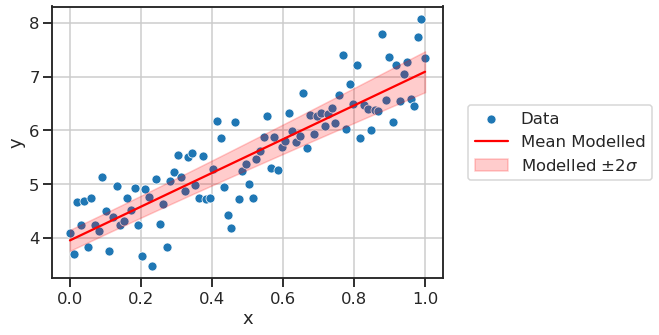

In [6]:
# plot the data with the model predictions from posterior draws
plot_linear_data(
    x_data, y_data,
    y_modelled=pred_y
)

In [7]:
def plot_hist(results, param_name):
    # results = results_rmse
    posterior_mean = results[param_name].mean()
    print('{:.3f} mean value of posterior'.format(posterior_mean))
    histogram_trace(results[param_name].values)

# use ipywidgets to get a "gui" dropdown to view all the parameters
interact(
    plot_hist, 
    results=fixed(results), 
    param_name=widgets.Dropdown(
        options=results.columns,
        value='w0',
        description='Parameter:',
    )
)

interactive(children=(Dropdown(description='Parameter:', options=('w0', 'b', 'tau', 'rmse'), value='w0'), Outp…

<function __main__.plot_hist(results, param_name)>